# 🧪 DDRM on Ultrasound .mat Input
This notebook loads a `.mat` ultrasound file, extracts the `bmode_GT` image, resizes and normalizes it, and prepares it for inference using a pretrained diffusion model.

In [1]:
import scipy.io
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
from PIL import Image

# Ensure GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Original shape: (156, 176)


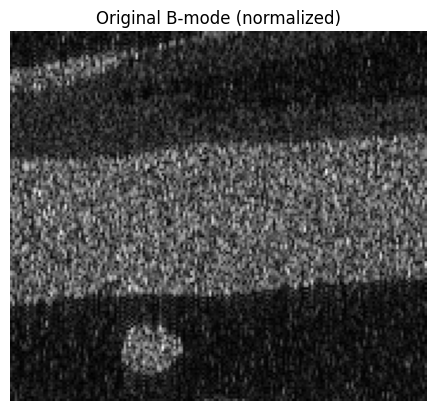

In [2]:
# Load the ultrasound .mat file
mat_path = "exp/datasets/anes_data/simu/1/data.mat"
mat_data = scipy.io.loadmat(mat_path)
bmode = mat_data['bmode_GT'].astype(np.float32)

# Normalize to [0,1]
bmode -= bmode.min()
bmode /= (bmode.max() + 1e-8)

# Show original shape
print("Original shape:", bmode.shape)

# Plot the image
plt.imshow(bmode, cmap='gray')
plt.title("Original B-mode (normalized)")
plt.axis('off')
plt.show()


In [4]:
# Convert to tensor and resize to 256×256
tensor = torch.from_numpy(bmode).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
resized = TF.resize(tensor, [256, 256])  # Resize to match model input
resized = resized.to(device)

# Convert 1-channel grayscale to 3-channel RGB (repeat along channel dimension)
resized = resized.repeat(1, 3, 1, 1)  # Shape becomes [1, 3, 256, 256]

# Normalize to [-1, 1]
resized = resized * 2 - 1

print("Prepared input shape:", resized.shape)


Prepared input shape: torch.Size([1, 3, 256, 256])


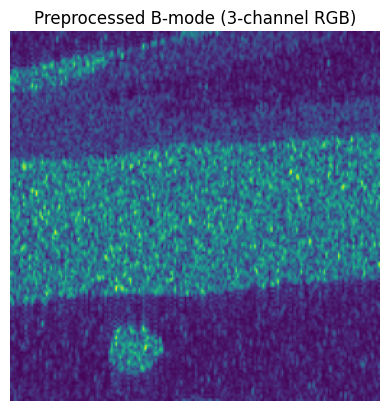

In [9]:
# Properly squeeze only the batch dimension
visual = resized.squeeze(0)  # Shape: [3, 256, 256]

# Save image
save_image(visual, "bmode_rgb_resized.png")

# Convert to numpy and plot
img_display = visual.permute(1, 2, 0).cpu().numpy()  # Shape: [256, 256, 3]
plt.imshow(img_display)
plt.title("Preprocessed B-mode (3-channel RGB)")
plt.axis('off')
plt.show()


In [11]:
import torch
from torchvision.utils import save_image

# Skip normalization if just saving for visualization
visual = resized.squeeze(0)  # shape: [3, 256, 256]

# Simple contrast enhancement (clip and rescale)
visual = visual - visual.min()
visual = visual / (visual.max() + 1e-8)

save_image(visual, "bmode_rgb_rescaled.png")
print("Saved as bmode_rgb_rescaled.png")


Saved as bmode_rgb_rescaled.png


In [3]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('exp/datasets/anes_data/simu/1/data.mat')

# Filter out meta keys starting with '__'
for key in mat:
    if not key.startswith('__'):
        value = mat[key]
        print(f"Variable: {key}, Type: {type(value)}, Shape: {value.shape if hasattr(value, 'shape') else 'N/A'}")


Variable: GT_rf, Type: <class 'numpy.ndarray'>, Shape: (156, 176)
Variable: PSF_estim, Type: <class 'numpy.ndarray'>, Shape: (13, 13)
Variable: bmode, Type: <class 'numpy.ndarray'>, Shape: (156, 176)
Variable: bmode_GT, Type: <class 'numpy.ndarray'>, Shape: (156, 176)
Variable: psf_ref, Type: <class 'numpy.ndarray'>, Shape: (11, 9)
Variable: rf, Type: <class 'numpy.ndarray'>, Shape: (156, 176)


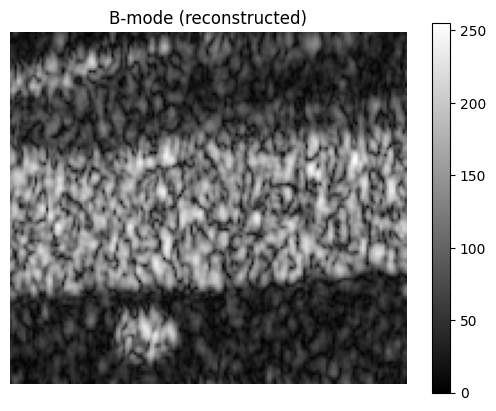

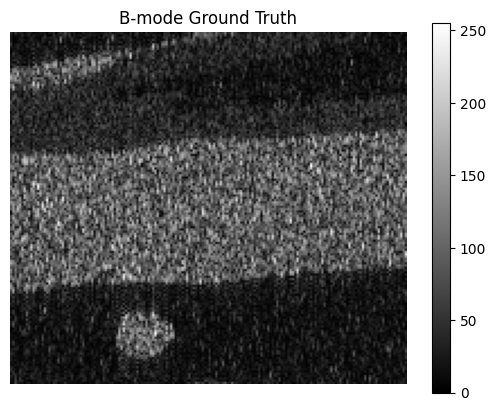

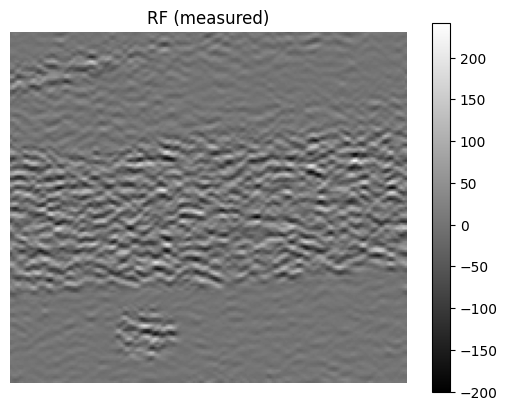

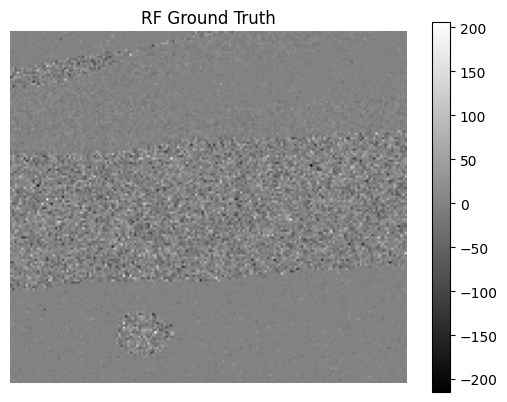

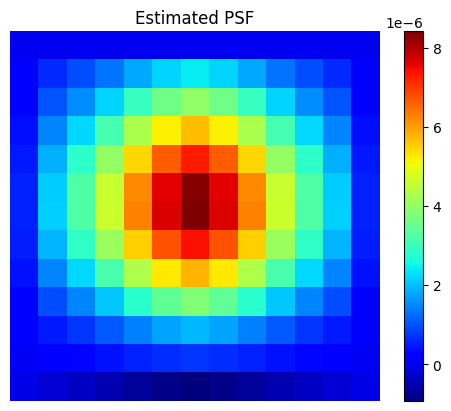

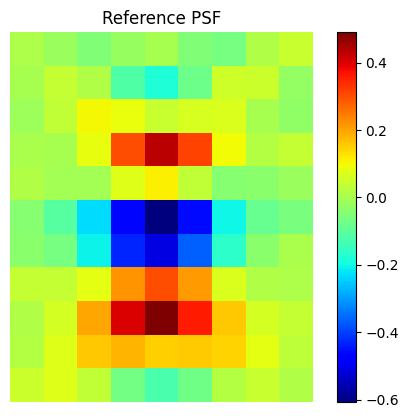

In [4]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load the .mat file
mat = scipy.io.loadmat('exp/datasets/anes_data/simu/1/data.mat')

# Define a visualization function
def show_image(data, title, cmap='gray'):
    plt.figure()
    plt.imshow(data, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize each variable
if 'bmode' in mat:
    show_image(mat['bmode'], 'B-mode (reconstructed)', cmap='gray')

if 'bmode_GT' in mat:
    show_image(mat['bmode_GT'], 'B-mode Ground Truth', cmap='gray')

if 'rf' in mat:
    show_image(mat['rf'], 'RF (measured)', cmap='gray')

if 'GT_rf' in mat:
    show_image(mat['GT_rf'], 'RF Ground Truth', cmap='gray')

if 'PSF_estim' in mat:
    show_image(mat['PSF_estim'], 'Estimated PSF', cmap='jet')

if 'psf_ref' in mat:
    show_image(mat['psf_ref'], 'Reference PSF', cmap='jet')


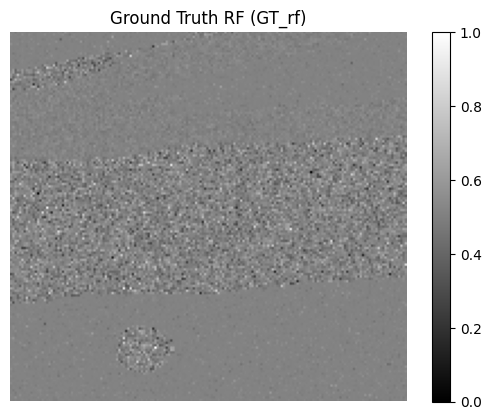

In [5]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# Load the .mat file
mat_path = 'exp/datasets/anes_data/simu/1/data.mat'  # Change this path if needed
mat = scipy.io.loadmat(mat_path)

# Extract and convert GT_rf to float32
gt_rf = mat['GT_rf'].astype(np.float32)

# Normalize for better visualization (optional)
gt_rf -= gt_rf.min()
gt_rf /= gt_rf.max() + 1e-8

# Display the Ground Truth RF image
plt.imshow(gt_rf, cmap='gray', aspect='auto')
plt.title("Ground Truth RF (GT_rf)")
plt.axis('off')
plt.colorbar()
plt.show()


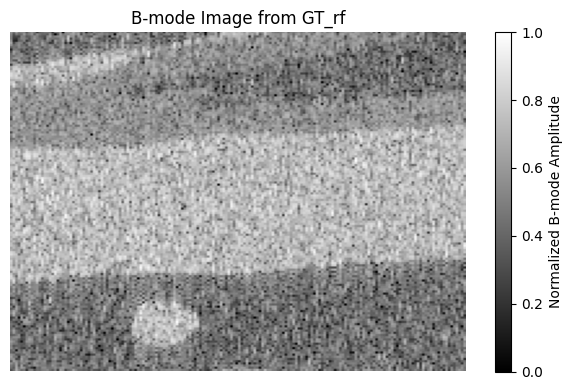

In [12]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def rf_to_bmode(rf_data, dyn_range=60):
    """Convert RF image to B-mode using Hilbert transform and log compression."""
    analytic = hilbert(rf_data, axis=0)
    envelope = np.abs(analytic)
    envelope /= envelope.max()
    bmode_db = 20 * np.log10(envelope + 1e-8)
    bmode_db = np.clip(bmode_db, -dyn_range, 0)
    return (bmode_db + dyn_range) / dyn_range  # Normalize to [0,1]

# Load GT_rf
mat_path = 'exp/datasets/anes_data/simu/1/data.mat'
mat = scipy.io.loadmat(mat_path)
gt_rf = mat['GT_rf'].astype(np.float32)

# Convert to B-mode
gt_bmode = rf_to_bmode(gt_rf)

# Plot B-mode image
plt.figure(figsize=(6, 4))
plt.imshow(gt_bmode, cmap='gray', aspect='auto')
plt.title("B-mode Image from GT_rf")
plt.axis('off')
plt.colorbar(label='Normalized B-mode Amplitude')
plt.tight_layout()
plt.show()


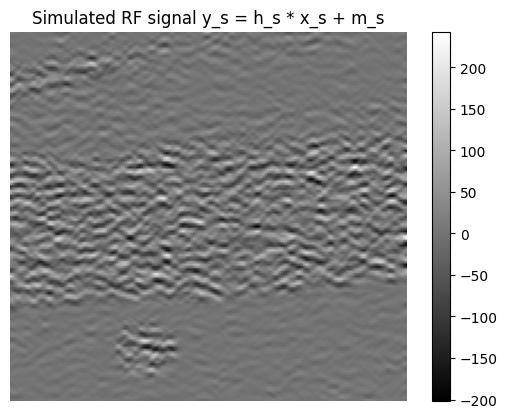

In [6]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# Load .mat file
mat = scipy.io.loadmat('exp/datasets/anes_data/simu/1/data.mat')
x_s = mat['GT_rf'].astype(np.float32)       # Ground truth reflectivity
h_s = mat['psf_ref'].astype(np.float32)     # PSF (reference)

# Normalize PSF to ensure energy conservation
h_s /= np.sum(h_s)

# Convolve GT_rf with psf_ref using 2D convolution
y_s = convolve2d(x_s, h_s, mode='same', boundary='symm')

# Add small Gaussian noise (adjust std as needed)
noise_std = 0.01 * np.std(y_s)  # 1% of signal std
m_s = np.random.normal(0, noise_std, size=y_s.shape)
y_s_noisy = y_s + m_s

# Display the simulated observed signal
plt.imshow(y_s_noisy, cmap='gray', aspect='auto')
plt.title("Simulated RF signal y_s = h_s * x_s + m_s")
plt.axis('off')
plt.colorbar()
plt.show()


In [12]:
!python main_mat.py \
  --mat_dir    exp/datasets/anes_data/simu/1 \
  --mat_list   exp/datasets/anes_data/simu/1/mat_list.txt \
  --psf_path   /projects/minds/PDAS-M2-2025/MIRDDRM/psf_GT_0.mat \
  --model_path exp/logs/imagenet/256x256_diffusion_uncond.pt \
  --config     deblur_us.yml \
  --doc        mat_demo_rf \
  --key        rf \
  --timesteps  20 \
  --eta        0.85 \
  --etaB       1.0 \
  --deg        deblur_bccb \
  --sigma_0    0 \
  --output_dir mat_output_rf


Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/MIRDDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO:root:Using device: cuda
INFO:root:Using device: cuda
INFO - main.py - 2025-05-05 17:53:55,288 - Using device: cuda
INFO:root:✅ Model instantiated and checkpoint loaded.
INFO - main_mat.py - 2025-05-05 17:54:01,152 - ✅ Model instantiated and checkpoint loaded.
INFO:root:Loading PSF from: /projects/minds/PDAS-M2-2025/MIRDDRM/psf_GT_0.mat
INFO - main_mat.py - 2025-05-05 17:54:01,152 - Loading PSF from: /proj

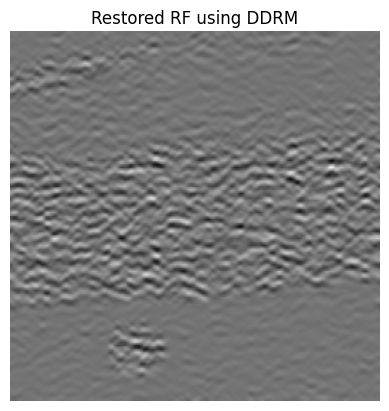

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('mat_output_rf/restored_ddrm.png')
plt.imshow(img, cmap='gray')
plt.title("Restored RF using DDRM")
plt.axis('off')
plt.show()


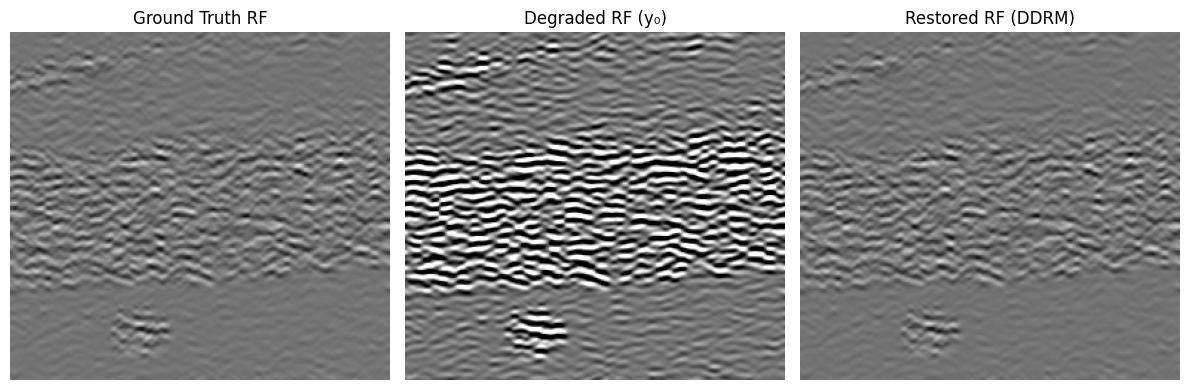

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread

# Load images in grayscale
gt = imread('mat_output_rf/ground_truth.png', as_gray=True)
degraded = imread('mat_output_rf/degraded_y0.png', as_gray=True)
restored = imread('mat_output_rf/restored_ddrm.png', as_gray=True)

# Create figure
plt.figure(figsize=(12, 4))

# Display images side by side
titles = ['Ground Truth RF', 'Degraded RF (y₀)', 'Restored RF (DDRM)']
images = [gt, degraded, restored]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray', aspect='auto')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
!python main_mat_rf.py \
  --mat_dir exp/datasets/anes_data/simu/1 \
  --mat_list exp/datasets/anes_data/simu/1/mat_list.txt \
  --psf_path /projects/minds/PDAS-M2-2025/MIRDDRM/psf_GT_0.mat \
  --model_path exp/logs/imagenet/256x256_diffusion_uncond.pt \
  --config deblur_us.yml \
  --doc mat_demo_rf \
  --key rf \
  --timesteps 20 \
  --eta 0.85 \
  --etaB 1.0 \
  --deg deblur_bccb \
  --sigma_0 0 \
  --output_dir mat_output_rf


Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/MIRDDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO:root:Using device: cuda
INFO:root:Using device: cuda
INFO - main.py - 2025-05-05 18:04:57,359 - Using device: cuda
INFO:root:✅ Model instantiated and checkpoint loaded.
INFO - main_mat_rf.py - 2025-05-05 18:05:03,472 - ✅ Model instantiated and checkpoint loaded.
INFO:root:Loading PSF from: /projects/minds/PDAS-M2-2025/MIRDDRM/psf_GT_0.mat
INFO - main_mat_rf.py - 2025-05-05 18:05:03,472 - Loading PSF from:

In [7]:
import scipy.io
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np

# Load .mat files
gt_mat = scipy.io.loadmat('mat_output_rf/ground_truth.mat')
restored_mat = scipy.io.loadmat('mat_output_rf/restored_ddrm.mat')

# Extract data
gt = gt_mat['GT_rf_resized'].astype(np.float32)
restored = restored_mat['rf_restored'].astype(np.float32)

# Normalize to [0, 1] for fair SSIM/PSNR comparison (optional but common)
gt -= gt.min()
gt /= gt.max() + 1e-8

restored -= restored.min()
restored /= restored.max() + 1e-8

# Compute metrics
psnr = peak_signal_noise_ratio(gt, restored, data_range=1.0)
ssim = structural_similarity(gt, restored, data_range=1.0)

# Output
print(f"📊 PSNR: {psnr:.2f} dB")
print(f"📊 SSIM: {ssim:.4f}")


📊 PSNR: 47.63 dB
📊 SSIM: 0.9989
